In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import trange

***import image***

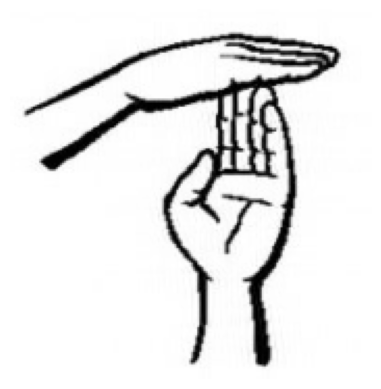

Image shape: (178, 174)


In [2]:
I = cv2.imread("sample1.png", 1)
I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
plt.imshow(I, cmap="gray")
plt.axis("off")
plt.show()
print("Image shape:", I.shape)

(160, 160)

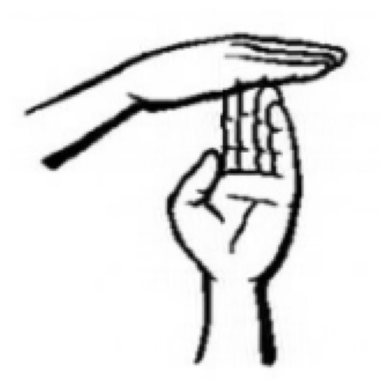

In [3]:
I = cv2.resize(I,(160, 160))
plt.imshow(I, cmap = "gray");plt.axis("off")
I.shape

***Base function***

  0%|          | 0/8 [00:00<?, ?it/s]

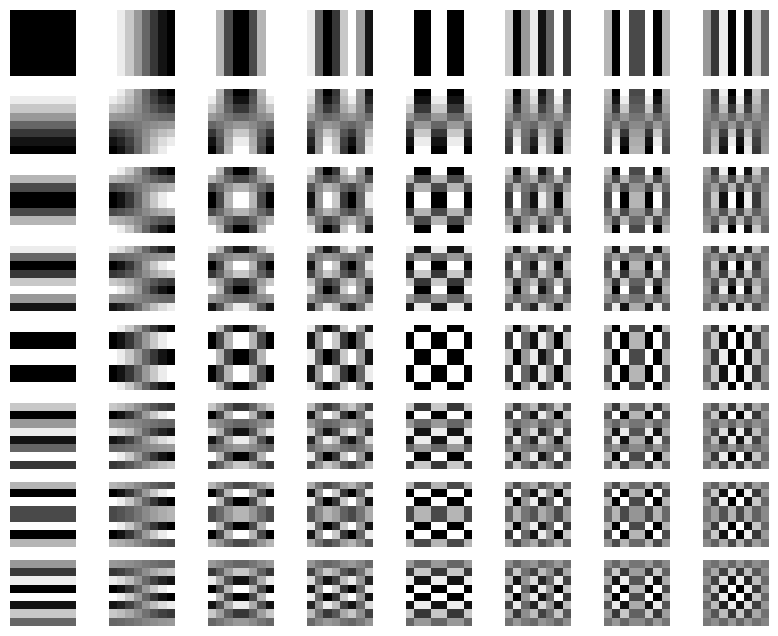

In [4]:
coef_base = np.zeros((8, 8, 8, 8))
for u in trange(8):
    for v in range(8):
        for x in range(8):
            for y in range(8):
                coef_base[u, v, x, y] = np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
fig, axes = plt.subplots(8, 8, figsize=(10, 8))
for u in range(8):
    for v in range(8):
        axes[u, v].imshow(coef_base[u, v], cmap="gray")
        axes[u, v].axis("off")
plt.show()

***Base quantizition***

In [5]:
def QQC(degree):
    newQ = np.zeros((8, 8), dtype=np.uint8)
    if 1 < degree < 50:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip((50 / degree) * Q[i, j], 0, 255)
        return newQ
    elif 50 < degree < 100:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip(((100 - degree) / 50) * Q[i, j], 0, 255)
        return newQ
    elif degree == 50:
        return Q
    else:
        return "sorry but not possible"

Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])


***Apply the DCT***

In [6]:
I[:8, :8]

array([[255, 255, 255, 255, 255, 255, 255, 255],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [7]:
num_blocks = (I.shape[0] // 8, I.shape[1] // 8)
blocks = np.empty((num_blocks[0], num_blocks[1], 8, 8))
for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
    for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
        blocks[i, j] = I[k:k + 8, l:l + 8]
width, height, _, _ = blocks.shape

In [8]:
blocks[5,0]

array([[254., 254., 251., 253., 251., 253., 252., 251.],
       [254., 254., 252., 252., 252., 252., 252., 253.],
       [254., 254., 251., 253., 252., 248., 249., 248.],
       [254., 254., 253., 251., 249., 250., 229., 175.],
       [254., 254., 253., 253., 253., 241., 166.,  52.],
       [254., 254., 252., 251., 252., 239., 168., 102.],
       [254., 254., 252., 251., 250., 244., 223., 220.],
       [255., 254., 253., 253., 251., 252., 251., 252.]])

In [9]:
def DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = np.subtract(np.copy(arr), 128)
    for row in trange(width):
        for column in range(height):
            for u in range(8):
                au = 1
                if u == 0: au = np.sqrt(1 / 2)
                for v in range(8):
                    sumGx = 0
                    av = 1
                    if v == 0: av = np.sqrt(1 / 2)
                    for x in range(8):
                        for y in range(8):
                            sumGx += g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = (1/4) * au * av * sumGx
    return result

dctM = DCT(blocks)

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
dctM[0,0]

array([[ 1.01200000e+03,  3.01457752e-14, -9.79737694e-14,
         6.02915504e-14,  2.00971835e-14,  3.16530640e-13,
        -1.90923243e-13, -1.01741991e-13],
       [-1.96157056e+00, -1.77635684e-14,  1.06581410e-14,
        -3.55271368e-15, -3.55271368e-15, -7.10542736e-15,
         1.77635684e-15, -7.99360578e-15],
       [ 2.61312593e+00, -1.06581410e-14, -2.13162821e-14,
         0.00000000e+00,  3.55271368e-15, -3.55271368e-15,
        -1.77635684e-15, -6.21724894e-15],
       [ 1.66293922e+00,  3.55271368e-15,  7.10542736e-15,
         3.55271368e-15,  0.00000000e+00,  7.10542736e-15,
         8.88178420e-15, -4.44089210e-15],
       [ 6.02915504e-14,  7.10542736e-15,  7.10542736e-15,
        -1.06581410e-14,  0.00000000e+00, -3.55271368e-15,
         0.00000000e+00, -7.99360578e-15],
       [ 1.11114047e+00,  2.84217094e-14,  0.00000000e+00,
        -1.06581410e-14,  8.88178420e-15, -1.77635684e-15,
         6.21724894e-15, -5.32907052e-15],
       [ 1.08239220e+00,  1.953992

In [11]:
def quantizition(arr, Q):
    quant = QQC(Q)
    totest = np.copy(arr)
    finalStep = np.zeros_like(arr)
    for i in range(width):
        for j in range(height):
            for x in range(8):
                for y in range(8):
                    finalStep[i, j, x, y] = round(totest[i, j, x, y] / quant[x, y])
    return finalStep

qun = quantizition(dctM, 50)

In [12]:
qun[0,0]

array([[63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

***reconstruct by 30, 50 and 70***

In [13]:
def Iquantizition(arr, Q):
    quant = QQC(Q)
    totest = np.copy(arr)
    finalStep = np.zeros_like(arr)
    for i in range(width):
        for j in range(height):
            for x in range(8):
                for y in range(8):
                    finalStep[i, j, x, y] = round(totest[i, j, x, y] * quant[x, y])
    return finalStep

Iqun = quantizition(dctM, 50)

In [14]:
Iqun[0, 0]

array([[63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [15]:
def energy_left(arr, energy):
    qunP = np.copy(arr)
    leftEnergy = round(8*energy/100)
    for i in range(width):
        for j in range(height):
            qunP[i, j, leftEnergy:] = 0
            qunP[i, j, :, leftEnergy:] = 0
    return qunP
newImg_70 = energy_left(Iqun, 70)
newImg_50 = energy_left(Iqun, 50)
newImg_30 = energy_left(Iqun, 30)
newImg = energy_left(Iqun, 100)

***Apply the IDCT***

In [16]:
def inv_DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = np.copy(arr)
    for row in trange(width):
        for column in range(height):
            for u in range(8):
                au = 1
                if u == 0: au = np.sqrt(1 / 2)
                for v in range(8):
                    sumGx = 0
                    av = 1
                    if v == 0: av = np.sqrt(1 / 2)
                    for x in range(8):
                        for y in range(8):
                            sumGx += g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = (1/4) * au * av * sumGx
    result += 128
    return result.astype(np.uint8)

In [17]:
inv_dct_30 = inv_DCT(np.array(newImg_30))
inv_dct_50 = inv_DCT(np.array(newImg_50))
inv_dct_70 = inv_DCT(np.array(newImg_70))
inv_dct = inv_DCT(qun)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
idct = inv_DCT(dctM)

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
def restord(img):
    cp = np.copy(img)
    new_Img = np.empty((I.shape[0], I.shape[1]), dtype = np.uint8)
    for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
        for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
            new_Img[k:k + 8, l:l + 8] = cp[i, j]
    return new_Img

In [20]:
new_Img = restord(inv_dct)
new_Img_30 = restord(inv_dct_30)
new_Img_50 = restord(inv_dct_50)
new_Img_70 = restord(inv_dct_70)

In [21]:
nImg = restord(idct)

***Result***

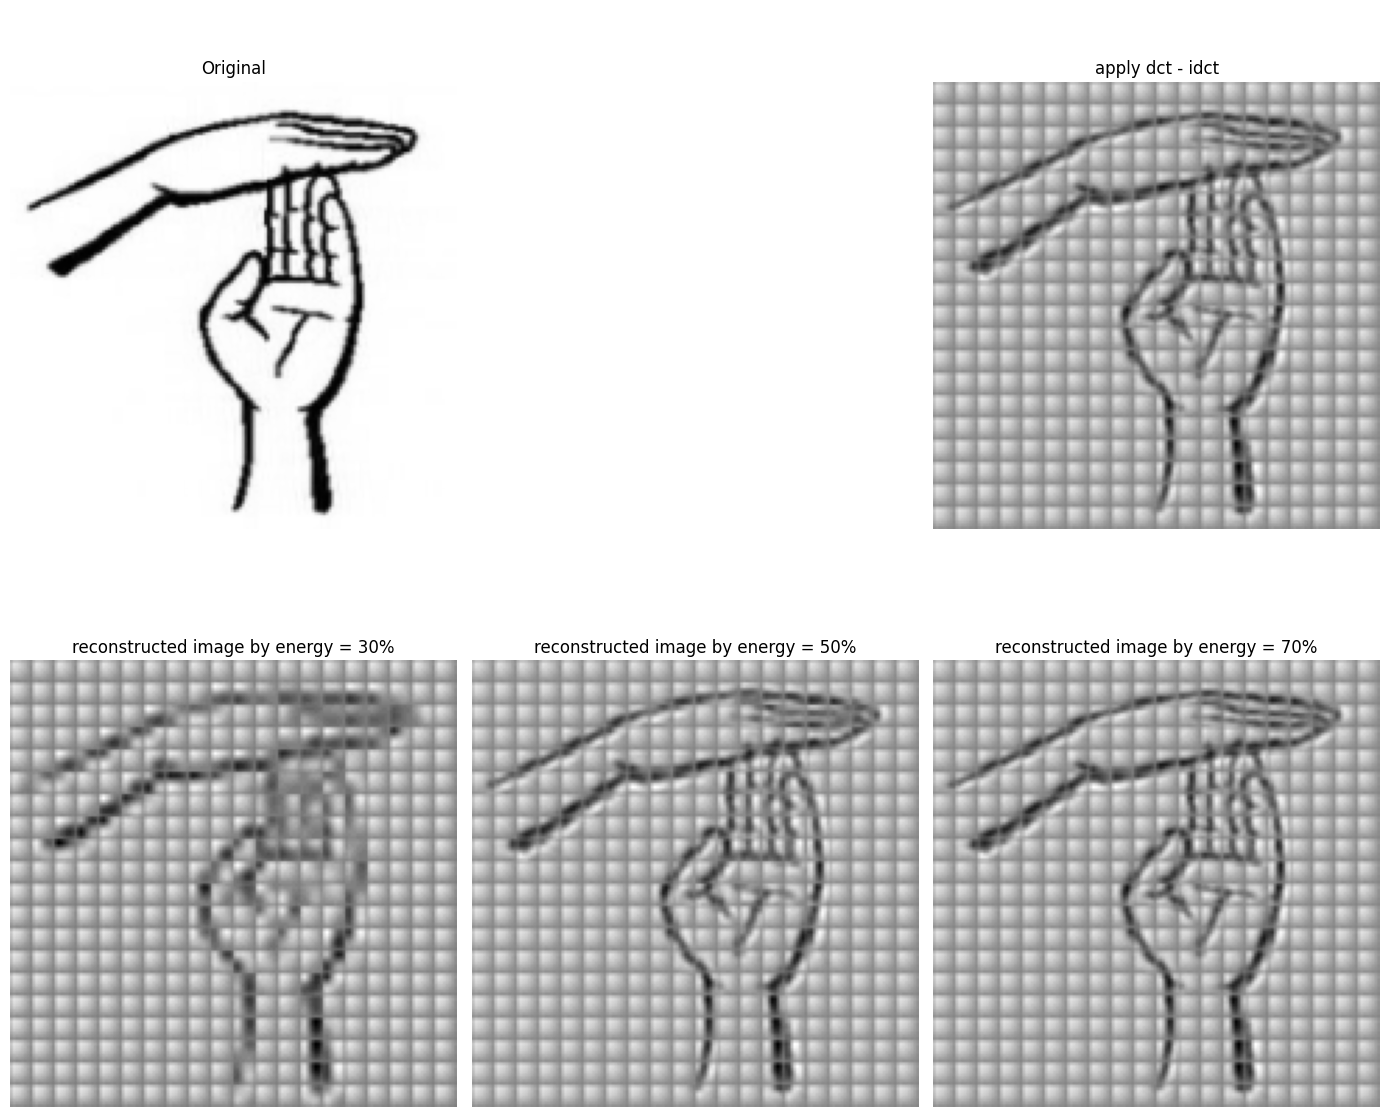

In [22]:
fig , axe = plt.subplots(nrows=2, ncols=3, figsize=(14, 12))
axe[0, 0].imshow(I, cmap="gray");axe[0, 0].axis("off");axe[0, 0].set_title("Original")
axe[0, 1].axis("off")
axe[0, 2].imshow(new_Img, cmap="gray");axe[0, 2].axis("off");axe[0, 2].set_title("apply dct - idct")
axe[1, 0].imshow(new_Img_30, cmap="gray");axe[1, 0].axis("off");axe[1, 0].set_title("reconstructed image by energy = 30%")
axe[1, 1].imshow(new_Img_50, cmap="gray");axe[1, 1].axis("off");axe[1, 1].set_title("reconstructed image by energy = 50%")
axe[1, 2].imshow(new_Img_70, cmap="gray");axe[1, 2].axis("off");axe[1, 2].set_title("reconstructed image by energy = 70%")
plt.tight_layout()
plt.show()

***Apply zig-zag order***

In [23]:
def zigzag(mat):
    index_order = sorted(((x, y) for x in range(8) for y in range(8)), key=lambda x: (x[0] + x[1], -x[1] if (x[0] + x[1]) % 2 else x[1]))
    arr = np.copy(mat)
    order_array = np.zeros((width, height, 64))
    for u in range(width):
        for v in range(height):
            order_array[u, v] = [arr[u, v, i, j] for i, j in index_order]
    return order_array

orderArray = zigzag(qun)

In [24]:
width_o, height_o, deep_o = orderArray.shape
DPCM = np.zeros_like(orderArray)
for x in range(width_o):
    for y in range(height_o) : 
        if x == 0 and y == 0 : DPCM[x, y, 0] = orderArray[x, y, 0]
        elif x == 0 :
            sub = orderArray[x, y - 1, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
        elif y == 0 :
            sub = orderArray[x - 1, y, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
        else:
            sub = orderArray[x - 1, y - 1, 0]
            DPCM[x, y, 0] = orderArray[x, y, 0] - sub
DPCM = np.round(DPCM)

In [25]:
ac = np.zeros_like(DPCM, dtype=object)
for x in range(width_o):
    for y in range(height_o):
        counter_zero = 0
        for z in range (deep_o):
            if  z == 0:  ac[x, y, z] =int(DPCM[x, y, 0])
            elif orderArray[x, y, z] == 0 : counter_zero+=1;continue
            else: 
                ac[x, y, z] = np.array([(counter_zero, int.bit_length(int(orderArray[x, y, z]))), int(orderArray[x, y, z])], dtype=object)
                counter_zero = 0
        if counter_zero != 0:ac[x, y, -counter_zero] = (0, 0)
        elif counter_zero == 63:ac[x, y, 1] = (0, 0)

In [26]:
ac[17, 10]

array([-48, array([(0, 5), 17], dtype=object),
       array([(0, 1), 1], dtype=object), array([(0, 1), 1], dtype=object),
       array([(0, 4), 13], dtype=object),
       array([(0, 6), 62], dtype=object),
       array([(0, 4), -12], dtype=object),
       array([(0, 3), -7], dtype=object),
       array([(0, 2), -2], dtype=object),
       array([(0, 1), 1], dtype=object), 0,
       array([(1, 1), 1], dtype=object),
       array([(0, 2), -2], dtype=object),
       array([(0, 4), -9], dtype=object),
       array([(0, 3), -4], dtype=object), 0,
       array([(1, 2), 2], dtype=object), array([(0, 2), 2], dtype=object),
       array([(0, 2), -2], dtype=object),
       array([(0, 2), 2], dtype=object), 0, 0, 0,
       array([(3, 1), -1], dtype=object), 0, 0, 0, 0, 0, 0, 0, 0,
       array([(8, 1), -1], dtype=object), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       array([(10, 1), -1], dtype=object), (0, 0), 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [27]:
def int_to_custom_binary(n,):
    if n == 0: return ""
    binary = bin(abs(n))[2:]  
    if n < 0:binary = binary.replace("0", "2").replace("1", "0").replace("2", "1")
    return binary

In [28]:
ac[2, 14]

array([-18, array([(0, 2), -2], dtype=object),
       array([(0, 4), 11], dtype=object),
       array([(0, 3), -4], dtype=object),
       array([(0, 2), -3], dtype=object),
       array([(0, 1), 1], dtype=object), array([(0, 1), 1], dtype=object),
       array([(0, 1), -1], dtype=object),
       array([(0, 3), 5], dtype=object),
       array([(0, 5), 29], dtype=object),
       array([(0, 5), 20], dtype=object),
       array([(0, 3), -6], dtype=object),
       array([(0, 2), 2], dtype=object),
       array([(0, 1), -1], dtype=object),
       array([(0, 1), -1], dtype=object), 0,
       array([(1, 1), 1], dtype=object),
       array([(0, 2), -2], dtype=object),
       array([(0, 1), -1], dtype=object),
       array([(0, 3), 5], dtype=object),
       array([(0, 3), -5], dtype=object), 0, 0,
       array([(2, 1), -1], dtype=object),
       array([(0, 1), 1], dtype=object), 0, 0, 0, 0, 0, 0, 0, 0,
       array([(8, 1), -1], dtype=object), (0, 0), 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0

In [90]:
dc_huffman_tables = {
    0: "00",
    1: "010",
    2: "011",
    3: "100",
    4: "101",
    5: "110",
    6: "1110",
    7: "11110",
    8: "111110",
    9: "1111110",
    10: "11111110",
    11: "111111110"
}
ac_huffman_tables = {
    (0, 1): '00',
    (0, 2): '01',
    (0, 3): '100',
    (0, 4): '1011',
    (0, 5): '11010',
    (0, 6): '1111000',
    (0, 7): '11111000',
    (0, 8): '1111110110',
    (0, 9): '1111111110000010',
    (0, 10): '1111111110000011',
    (1, 1): '1100',
    (1, 2): '11011',
    (1, 3): '1111001',
    (1, 4): '111110110',
    (1, 5): '11111110110',
    (1, 6): '1111111110000100',
    (1, 7): '1111111110000101',
    (1, 8): '1111111110000110',
    (1, 9): '1111111110000111',
    (1, 10): '1111111110001000',
    (2, 1): '11100',
    (2, 2): '11111001',
    (2, 3): '1111110111',
    (2, 4): '111111110100',
    (2, 5): '1111111110001001',
    (2, 6): '1111111110001010',
    (2, 7): '1111111110001011',
    (2, 8): '1111111110001100',
    (2, 9): '1111111110001101',
    (2, 10): '1111111110001110',
    (3, 1): '111010',
    (3, 2): '111110111',
    (3, 3): '111111110101',
    (3, 4): '1111111110001111',
    (3, 5): '1111111110010000',
    (3, 6): '1111111110010001',
    (3, 7): '1111111110010010',
    (3, 8): '1111111110010011',
    (3, 9): '1111111110010100',
    (3, 10): '1111111110010101',
    (4, 1): '111011',
    (4, 2): '1111111000',
    (4, 3): '1111111110010110',
    (4, 4): '1111111110010111',
    (4, 5): '1111111110011000',
    (4, 6): '1111111110011001',
    (4, 7): '1111111110011010',
    (4, 8): '1111111110011011',
    (4, 9): '1111111110011100',
    (4, 10): '1111111110011101',
    (5, 1): '1111010',
    (5, 2): '11111110111',
    (5, 3): '1111111110011110',
    (5, 4): '1111111110011111',
    (5, 5): '1111111110100000',
    (5, 6): '1111111110100001',
    (5, 7): '1111111110100010',
    (5, 8): '1111111110100011',
    (5, 9): '1111111110100100',
    (5, 10): '1111111110100101',
    (6, 1): '1111011',
    (6, 2): '111111110110',
    (6, 3): '1111111110100110',
    (6, 4): '1111111110100111',
    (6, 5): '1111111110101000',
    (6, 6): '1111111110101001',
    (6, 7): '1111111110101010',
    (6, 8): '1111111110101011',
    (6, 9): '1111111110101100',
    (6, 10): '1111111110101101',
    (7, 1): '11111010',
    (7, 2): '111111110111',
    (7, 3): '1111111110101110',
    (7, 4): '1111111110101111',
    (7, 5): '1111111110110000',
    (7, 6): '1111111110110001',
    (7, 7): '1111111110110010',
    (7, 8): '1111111110110011',
    (7, 9): '1111111110110100',
    (7, 10): '1111111110110101',
    (8, 1): '111111000',
    (8, 2): '111111111000000',
    (8, 3): '1111111110110110',
    (8, 4): '1111111110110111',
    (8, 5): '1111111110111000',
    (8, 6): '1111111110111001',
    (8, 7): '1111111110111010',
    (8, 8): '1111111110111011',
    (8, 9): '1111111110111100',
    (8, 10): '1111111110111101',
    (9, 1): '111111001',
    (9, 2): '1111111110111110',
    (9, 3): '1111111110111111',
    (9, 4): '1111111111000000',
    (9, 5): '1111111111000001',
    (9, 6): '1111111111000010',
    (9, 7): '1111111111000011',
    (9, 8): '1111111111000100',
    (9, 9): '1111111111000101',
    (9, 10): '1111111111000110',
    (10, 1): '111111010',
    (10, 2): "1111111111010000",
    (10, 3): "1111111111010001",
    (10, 4): "1111111111010010",
    (10, 5): "1111111111010011",
    (10, 6): "1111111111010100",
    (10, 7): "1111111111010101",
    (10, 8): "1111111111010110",
    (10, 9): "1111111111010111",
    (10, 10): "1111111111011000",
    (11, 1): "11111111000",
    (11, 2): "1111111111011001",
    (11, 3): "1111111111011010",
    (11, 4): "1111111111011011",
    (11, 5): "1111111111011100",
    (11, 6): "1111111111011101",
    (11, 7): "1111111111011110",
    (11, 8): "1111111111011111",
    (11, 9): "1111111111100000",
    (11, 10): "1111111111100001",
    (12, 1): "1111111111100010",
    (11, 8): "1111111111011111",
    (11, 9): "1111111111100000",
    (11, 10): "1111111111100001",
    (12, 1): "1111111111100010",
    (12, 2): "1111111111100011",
    (12, 3): "1111111111100100",
    (12, 4): "1111111111100101",
    (12, 5): "1111111111100110",
    (12, 6): "1111111111100111",
    (12, 7): "1111111111101000",
    (12, 8): "1111111111101001",
    (12, 9): "1111111111101010",
    (12, 10): "1111111111101011",
    (13, 1): "1111111111101100",
    (13, 2): "1111111111101101",
    (13, 3): "1111111111101110",
    (13, 4): "1111111111101111",
    (13, 5): "1111111111110000",
    (13, 6): "1111111111110001",
    (13, 7): "1111111111110010",
    (13, 8): "1111111111110011",
    (13, 9): "1111111111110100",
    (13, 10): "1111111111110101",
    (14, 1): "1111111111110110",
    (14, 2): "1111111111110111",
    (14, 3): "1111111111111000",
    (14, 4): "1111111111111001",
    (14, 5): "1111111111111010",
    (14, 6): "1111111111111011",
    (14, 7): "1111111111111100",
    (14, 8): "1111111111111101",
    (14, 9): "1111111111111110",
    (14, 10): "1111111111111111",
    (15, 0): "11111111001"
}

In [88]:
type(ac[1, 7, 2])
# if type(ac[1, 7, 2]) is not list and ac[1, 7, 2] == 0  : print(False)
# else:print(True)
# ac[1, 7, 2]
ac[1, 16, 34]

array([(11, 1), 1], dtype=object)

In [ ]:
encode = np.zeros_like(ac, dtype = np.int128)
for x in range(width_o):
    for y in range(height_o):
        for z in range (deep_o):
            if z == 0: encode[x, y, z] = int(int_to_custom_binary(ac[x, y, z],) + dc_huffman_tables[int.bit_length(ac[0, 0, 0])])
            elif type(ac[x, y, z]) is tuple and ac[x, y, z] == (0, 0):encode[x, y, z] = 1010;break
            elif type(ac[x, y, z]) is not np.ndarray and ac[x, y, z] == 0  : continue
            else:
                if ac[x, y, z][0][0]>15:int("11111111001" + int_to_custom_binary(ac[x, y, z][1]))
                else:encode[x, y, z] =  int(ac_huffman_tables[ac[x, y, z][0]] + int_to_custom_binary(ac[x, y, z][1]))
                

In [ ]:
class BinaryTreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
tree = BinaryTreeNode(5)
tree.left = BinaryTreeNode(4)
tree.left.left = BinaryTreeNode(3)
tree.left.right = BinaryTreeNode(7)
tree.right = BinaryTreeNode(3)
tree.right.left = BinaryTreeNode(1)
tree.right.right = BinaryTreeNode(2)
def orderT (tree):
    if tree.left is not None:
        return orderT (tree.left)
    elif tree.right is not None:
        return orderT(tree.right)
    else: print (tree.value)
orderT(tree)